In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo

### Parameters
#### Beam parameters

In [2]:
wl_2w = 515.0  # (nm)
pulse_duration_2w = 0.18  # (ps)
energy_2w = 3e-6  # (J)
waist_2w = 11e-6  # (m)

wl_3w = 343.3  # (nm)
pulse_duration_3w = 0.18  # (ps)
energy_3w = 1e-6  # (J)
waist_3w = 11e-6  # (m)

rep_rate = 1  # (MHz)

#### Fiber parameters

In [3]:
beta2 = -1.2  # (ps^2/km)
beta3 = 0.00  # (ps^3/km)
beta4 = 0.005  # (ps^4/km)

fiber_length = 50  # length in mm

alpha = 5e-4  # attentuation coefficient (dB/cm)
gamma = 1.605e-3  # Gamma (1/(W km))

fib_wl = 1064  # Center WL of fiber (nm)

raman = True  # Enable Raman effect?
steep = True  # Enable self steepening?

alpha = np.log((10 ** (alpha * 0.1))) * 100  # convert from dB/cm to 1/m

#### Simulation parameters

In [4]:
window = 10.0  # simulation window (ps)
steps = 100  # simulation steps
points = 2**13  # simulation points

### Simulation

#### Create pulses

In [5]:
# Generate 515 nm pulse
pulse_2w = pynlo.light.DerivedPulses.SechPulse(
    power=1,
    T0_ps=pulse_duration_2w / 1.76,
    center_wavelength_nm=wl_2w,
    time_window_ps=window,
    GDD=0.0,
    TOD=0.0,
    NPTS=points,
    frep_MHz=rep_rate,
    power_is_avg=False,
)
pulse_2w.set_epp(energy_2w)

# Generate 343 nm pulse
pulse = pynlo.light.DerivedPulses.SechPulse(
    power=1,
    T0_ps=pulse_duration_3w / 1.76,
    center_wavelength_nm=wl_3w,
    time_window_ps=window,
    GDD=0.0,
    TOD=0.0,
    NPTS=points,
    frep_MHz=rep_rate,
    power_is_avg=False,
)
pulse.set_epp(energy_3w)

# Add two pulses together
diff = pulse._centerfrequency - pulse_2w._centerfrequency
shift = np.floor(diff / pulse.dF_THz).astype(int)

spectrum_2w = np.roll(pulse_2w._get_AW(), -shift)
spectrum_3w = pulse._get_AW()
pulse.set_AW(spectrum_2w + spectrum_3w)

#### Create fiber

In [6]:
fiber = pynlo.media.fibers.fiber.FiberInstance()
fiber.generate_fiber(
    fiber_length * 1e-3,
    center_wl_nm=fib_wl,
    betas=(beta2, beta3, beta4),
    gamma_W_m=gamma * 1e-3,
    gvd_units="ps^n/km",
    gain=-alpha,
)

#### Propagate

In [7]:
evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(
    local_error=0.005,
    USE_SIMPLE_RAMAN=True,
    disable_Raman=np.logical_not(raman),
    disable_self_steepening=np.logical_not(steep),
)

y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber, n_steps=steps)

Pulse energy before Simple Fiber : 4000.0000000000005 nJ
pulse energy in  1.0939308312107199
copied as   1.0939308312107199
Step: 0 Distance remaining: 0.05
Pulse energy after: 0.003996570431265209 mJ
Step: 1 Distance remaining: 0.0495
Pulse energy after: 0.00399772603524878 mJ
Step: 2 Distance remaining: 0.049
Pulse energy after: 0.003998291743313719 mJ
Step: 3 Distance remaining: 0.0485
Pulse energy after: 0.003998617611269011 mJ
Step: 4 Distance remaining: 0.048
Pulse energy after: 0.003998823558037063 mJ
Step: 5 Distance remaining: 0.0475
Pulse energy after: 0.003998961273007047 mJ
Step: 6 Distance remaining: 0.047
Pulse energy after: 0.003993848811587364 mJ
Step: 7 Distance remaining: 0.0465
Pulse energy after: 0.003999135984155342 mJ
Step: 8 Distance remaining: 0.046000000000000006
Pulse energy after: 0.0039991782047100796 mJ
Step: 9 Distance remaining: 0.045500000000000006
Pulse energy after: 0.003999214954727528 mJ
Step: 10 Distance remaining: 0.045000000000000005
Pulse energy 

Pulse energy after: 0.003997011929274504 mJ
Step: 94 Distance remaining: 0.0030000000000000027
Pulse energy after: 0.0039974014150275464 mJ
Step: 95 Distance remaining: 0.0025000000000000022
Pulse energy after: 0.003997645615759859 mJ
Step: 96 Distance remaining: 0.0020000000000000018
Pulse energy after: 0.003997324360256894 mJ
Step: 97 Distance remaining: 0.0015000000000000013
Pulse energy after: 0.003996885428268154 mJ
Step: 98 Distance remaining: 0.0010000000000000009
Pulse energy after: 0.003996941859025506 mJ
Step: 99 Distance remaining: 0.0005000000000000004
Pulse energy after: 0.003997123408747748 mJ
Pulse energy after Simple Fiber : 0.003997366186560384 mJ


### Plotting

C:\Users\Jeremy\AppData\Local\Temp/ipykernel_28804/663661714.py:14: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(np.abs(num) ** 2)
C:\Users\Jeremy\AppData\Local\Temp/ipykernel_28804/663661714.py:14: RuntimeWarning: divide by zero encountered in log10
  return 10 * np.log10(np.abs(num) ** 2)


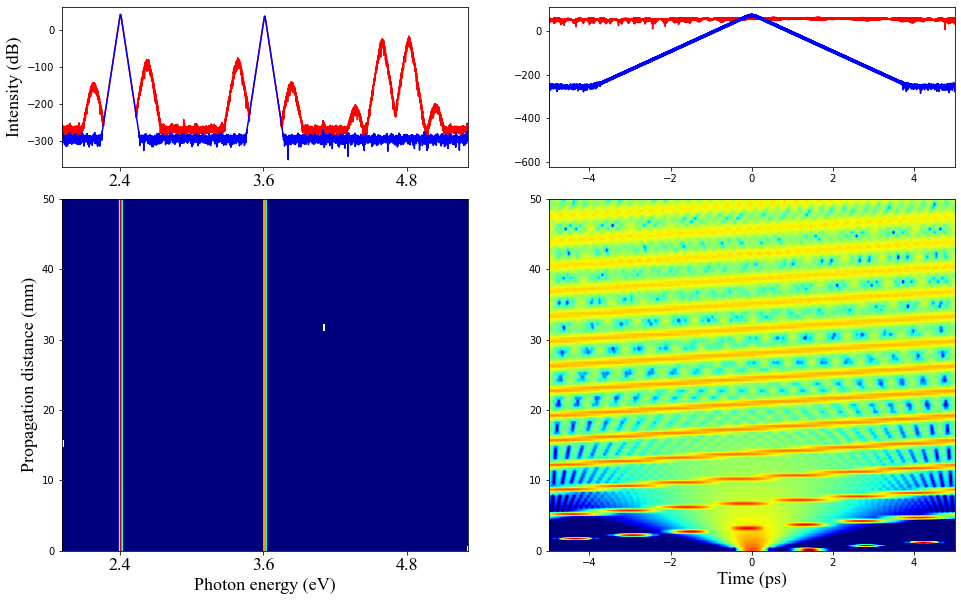

In [8]:
h = 4.136e-3  # Planck's constant (eV/THz)

# Set up plots for the results:
fig = plt.figure(figsize=(16, 10))
ax0 = plt.subplot2grid((3, 2), (0, 0), rowspan=1)
ax1 = plt.subplot2grid((3, 2), (0, 1), rowspan=1)
ax2 = plt.subplot2grid((3, 2), (1, 0), rowspan=2, sharex=ax0)
ax3 = plt.subplot2grid((3, 2), (1, 1), rowspan=2, sharex=ax1)

F = h * pulse.F_THz  # Frequency grid of pulse (THz)


def dB(num):
    return 10 * np.log10(np.abs(num) ** 2)


zW = dB(np.transpose(AW)[:, (F > 0)])
zT = dB(np.transpose(AT))

y_mm = y * 1e3  # convert distance to mm

ax0.plot(h * pulse_out.F_THz, dB(pulse_out.AW), color="r")
ax1.plot(pulse_out.T_ps, dB(pulse_out.AT), color="r")

ax0.plot(h * pulse.F_THz, dB(pulse.AW), color="b")
ax1.plot(pulse.T_ps, dB(pulse.AT), color="b")

extent = (np.min(F[F > 0]), np.max(F[F > 0]), 0, fiber_length)
ax2.imshow(
    zW,
    extent=extent,
    vmin=np.max(zW) - 40.0,
    vmax=np.max(zW),
    aspect="auto",
    origin="lower",
    cmap="jet",
)

extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y_mm), fiber_length)
ax3.imshow(
    zT,
    extent=extent,
    vmin=np.max(zT) - 40.0,
    vmax=np.max(zT),
    aspect="auto",
    origin="lower",
    cmap="jet",
)

fontname = "Times New Roman"

ax0.set_ylabel("Intensity (dB)", fontname=fontname, fontsize=18)
# ax0.set_ylim(-80, 0)
# ax1.set_ylim(-40, 40)

ax2.set_ylabel("Propagation distance (mm)", fontname=fontname, fontsize=18)
ax2.set_xlabel("Photon energy (eV)", fontname=fontname, fontsize=18)

ax3.set_xlabel("Time (ps)", fontname=fontname, fontsize=18)

ax0.set_xticks([2.4, 3.6, 4.8])
ax0.set_xticklabels(["2.4", "3.6", "4.8"], fontname=fontname, fontsize=18)

ax2.set_xticks([2.4, 3.6, 4.8])
ax2.set_xticklabels(["2.4", "3.6", "4.8"], fontname=fontname, fontsize=18)

plt.show()